In [1]:
import yfinance as yf # Module qui sert à télécharger les données
import pandas as pd # Module qui sert à manipuler les données
import matplotlib.pyplot as plt # Module qui sert à afficher les graphiques
from datetime import datetime # Module qui sert à manipuler les dates
from dateutil.relativedelta import relativedelta 
import numpy as np # Module qui sert à manipuler les tableaux

In [2]:
# Télécharger les données historiques pour les matières premières à l'aide de yfinance
def download_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    return data['Adj Close']

In [3]:
# Exemple de symboles pour les matières premières
tickers = [
    'CL=F',  # Pétrole brut
    'GC=F',  # Or 
    'SI=F',  # Argent 
    'HG=F',  # Cuivre 
    'ZW=F'   # Blé 
]
# Nom pour chaque symbole
noms = ['Pétrole brut', 'Or', 'Argent', 'Cuivre', 'Blé']

# Dates de début et de fin pour les données historiques
end_date = datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.now() - relativedelta(years=10)).strftime("%Y-%m-%d")

# Télécharger les données
data = download_data(tickers, start_date, end_date)
data = data.fillna(method='ffill') # Remplir les valeurs manquantes
data.head()

[*********************100%%**********************]  5 of 5 completed


,CL=F,GC=F,HG=F,SI=F,ZW=F
Date,,,,,
2014-04-09,103.599998,1305.500000,3.0660,19.754999,669.00
2014-04-10,103.400002,1320.099976,3.0680,20.077999,662.25
2014-04-11,103.739998,1318.699951,3.0660,19.933001,660.25
2014-04-14,104.050003,1327.199951,3.0670,19.999001,678.75
2014-04-15,103.750000,1300.000000,3.0165,19.478001,701.75


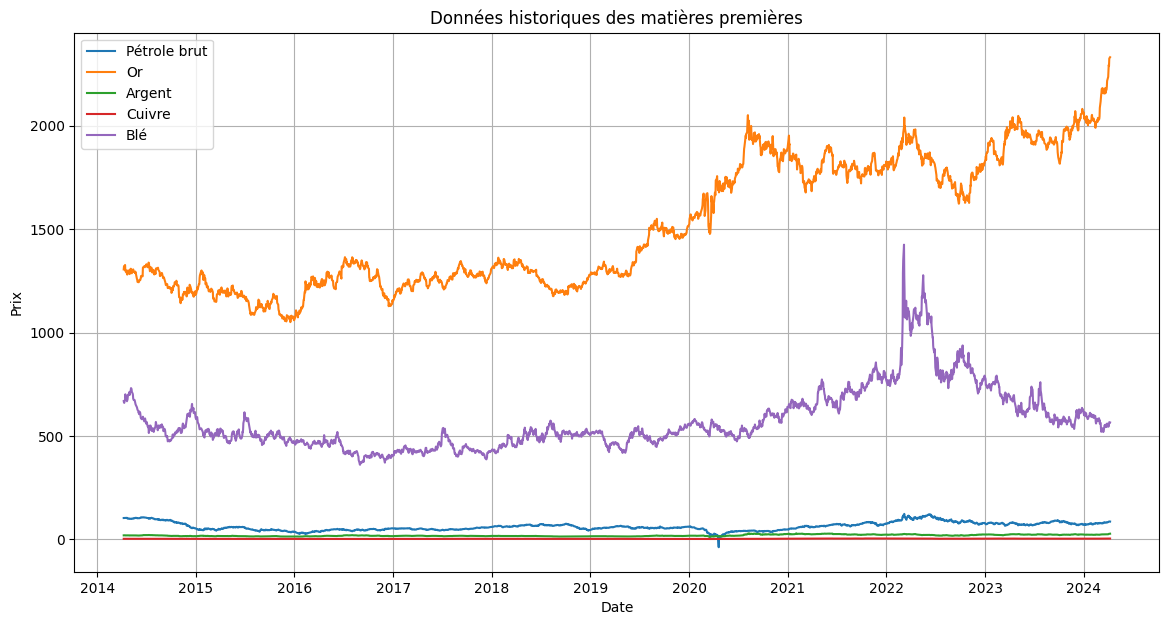

In [4]:
# Afficher les données historiques
plt.figure(figsize=(14, 7))
for ticker in tickers:
    if ticker in data.columns:
        plt.plot(data.index, data[ticker], label=ticker) 

plt.title('Données historiques des matières premières')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.legend(noms)
plt.grid(True)
plt.show()

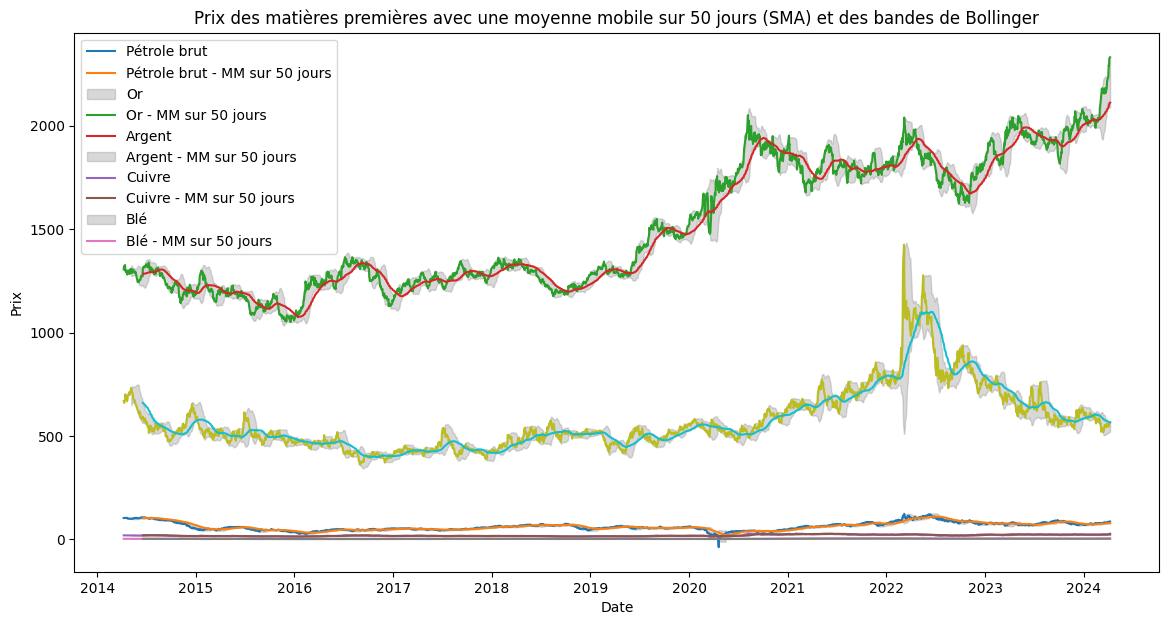

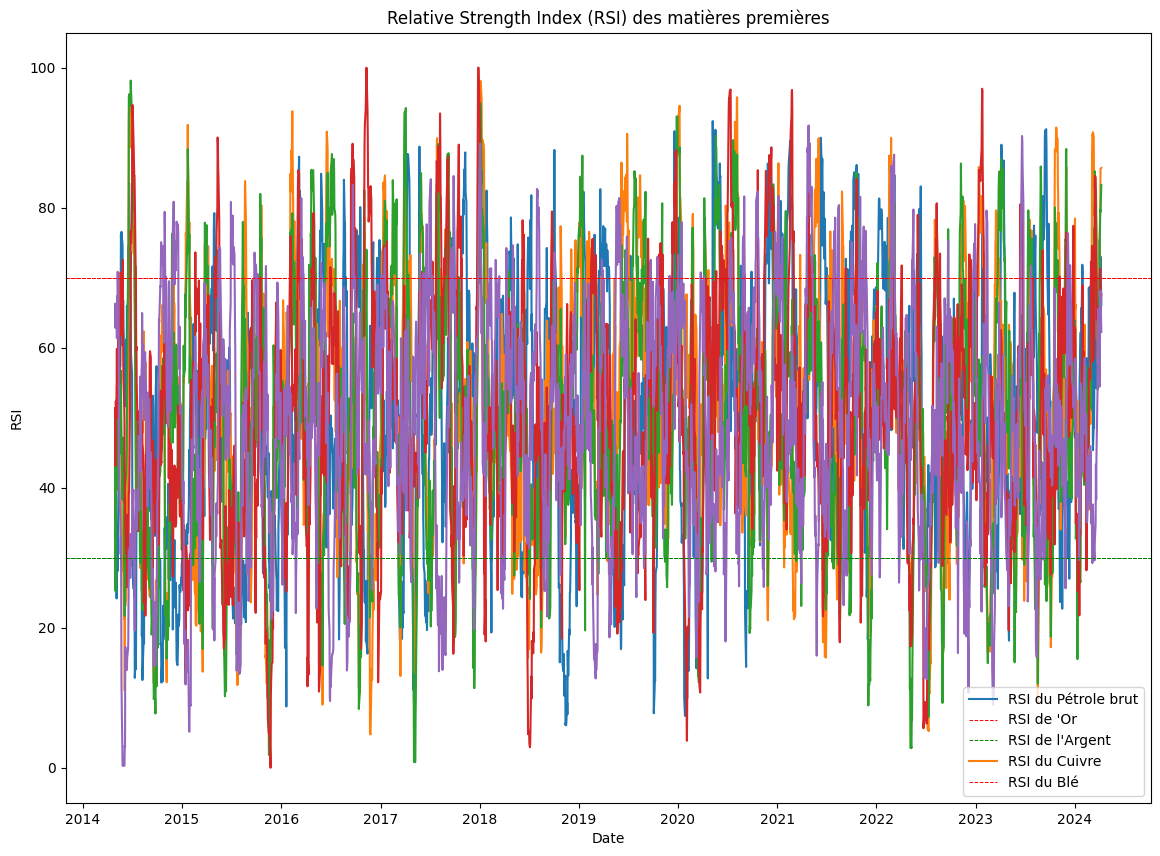

In [5]:
# Calcul de la moyenne mobile sur 50 jours 
sma_50 = data.rolling(window=50).mean()

# Calcul du Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

rsi_values = data.apply(lambda x: calculate_rsi(x))

# Calcul du Bollinger Bands
rolling_mean = data.rolling(window=20).mean()
rolling_std = data.rolling(window=20).std()
upper_band = rolling_mean + (rolling_std * 2)
lower_band = rolling_mean - (rolling_std * 2)

# Affichage des données 
plt.figure(figsize=(14, 7))

for ticker in tickers:
    plt.plot(data.index, data[ticker])
    plt.plot(sma_50.index, sma_50[ticker])
    plt.fill_between(data.index, upper_band[ticker], lower_band[ticker], color='gray', alpha=0.3)

noms = ['Pétrole brut', 'Pétrole brut - MM sur 50 jours', 'Or', 'Or - MM sur 50 jours', 'Argent', 'Argent - MM sur 50 jours', 'Cuivre', 'Cuivre - MM sur 50 jours', 'Blé', 'Blé - MM sur 50 jours']

plt.title('Prix des matières premières avec une moyenne mobile sur 50 jours (SMA) et des bandes de Bollinger')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.legend(noms)
plt.show()

plt.figure(figsize=(14, 10))
for ticker in tickers:
    plt.plot(rsi_values.index, rsi_values[ticker])
    plt.axhline(70, color='red', linestyle='--', linewidth=0.7)
    plt.axhline(30, color='green', linestyle='--', linewidth=0.7)

noms = ['RSI du Pétrole brut', "RSI de 'Or", "RSI de l'Argent", 'RSI du Cuivre', 'RSI du Blé']

plt.title('Relative Strength Index (RSI) des matières premières')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend(noms)
plt.show()

In [6]:
# Fonction pour calculer l'index de stratégie
def calculate_strategy_index(data, weights):
    n_indices = len(weights)
    strategy_index = pd.Series(index=data.index, dtype=float)
    strategy_index.iloc[0] = 1  # Initialize the first value to 1
    
    for t in range(1, len(data)):
        R_t = t - 1 
        ER_t = strategy_index.iloc[R_t] if t > 1 else 1
        sum_indices = 0
        for c in range(n_indices):
            UI_c_t = data.iloc[t, c]
            UI_c_R_t = data.iloc[R_t, c]
            sum_indices += weights[c] * (UI_c_t / UI_c_R_t - 1)
        strategy_index.iloc[t] = ER_t * (1 + sum_indices)
    
    return strategy_index

In [7]:
# Generer 100 combinations de poids aleatoires
n_strategies = 100
n_indices = len(data.columns)
weight_strategies = np.random.dirichlet(np.ones(n_indices), n_strategies) # On génère les poids avec la distribution Dirichlet

# Initialiser les variables pour stocker la meilleure stratégie
best_strategy_index = pd.Series(index=data.index, dtype=float)
best_final_index_value = -float('inf')
best_weights = None

In [8]:
for weights in weight_strategies:
    strategy_index = calculate_strategy_index(data, weights) # On calcule l'index de stratégie
    final_index_value = strategy_index.iloc[-1] 
    
    if final_index_value > best_final_index_value: # On détermine la meilleure stratégie
        best_final_index_value = final_index_value 
        best_strategy_index = strategy_index
        best_weights = weights # On sauvegarde les poids de la meilleure stratégie
        
# Afficher les paramètres de la meilleure stratégie
print("Best Strategy Index Final Value:", best_final_index_value)
print("Best Weights:", best_weights)

Best Strategy Index Final Value: 1.73746280151058
Best Weights: [0.00140299 0.83847564 0.02880499 0.04043253 0.09088385]


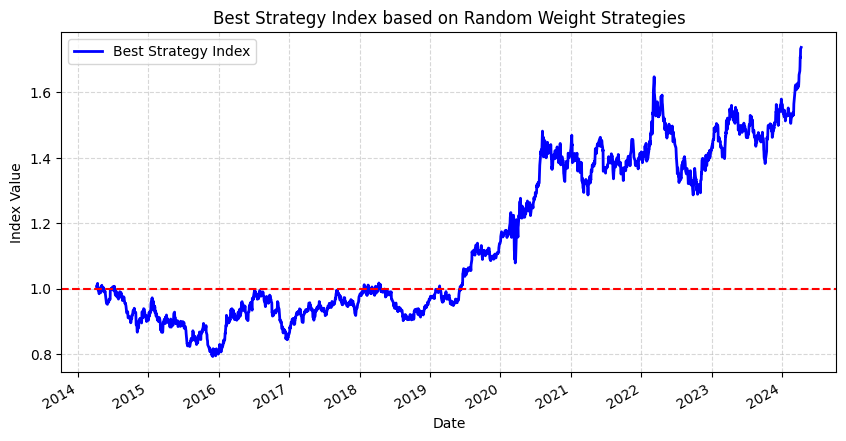

In [10]:
# Afficher l'index pour la meilleure stratégie
plt.figure(figsize=(10, 5))
best_strategy_index.plot(title='Best Strategy Index based on Random Weight Strategies', linewidth=2, color='blue')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(['Best Strategy Index'], loc='upper left')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.axhline(1, color='red', linestyle='--')
plt.show()